In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score

In [6]:
train_raw = pd.read_csv("SkinCancerTrain.csv")
test_raw = pd.read_csv("SkinCancerTestNoY.csv")

train_raw["is_train"] = True
test_raw["is_train"] = False
test_raw["Cancer"] = np.nan

df = pd.concat([train_raw, test_raw], axis=0).reset_index(drop=True)

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in ["ID", "is_train"]]

for col in numeric_cols:
    if df[col].isnull().any():
        df[f"{col}_missing_flag"] = df[col].isnull().astype(int)
        df[col] = df[col].fillna(df[col].median())

categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()
categorical_cols = [c for c in categorical_cols if c not in ["ID", "Cancer"]]

df[categorical_cols] = df[categorical_cols].fillna("Unknown")

df_encoded = pd.get_dummies(df, columns=categorical_cols, dummy_na=False)

df_encoded["target"] = df_encoded["Cancer"].apply(
    lambda x: 1 if x == "Malignant"
    else (0 if x == "Benign"
    else np.nan)
)

feature_cols = [
    c for c in df_encoded.columns
    if c not in ["ID", "Cancer", "target", "is_train"]
]

X_full = df_encoded[df_encoded["is_train"] == True][feature_cols]
y_full = df_encoded[df_encoded["is_train"] == True]["target"]

X_test_submission = df_encoded[df_encoded["is_train"] == False][feature_cols]

X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_full,
    test_size=0.2,
    random_state=42,
    stratify=y_full
)


0.6259850324607186
0.4900000000000001
0.5877


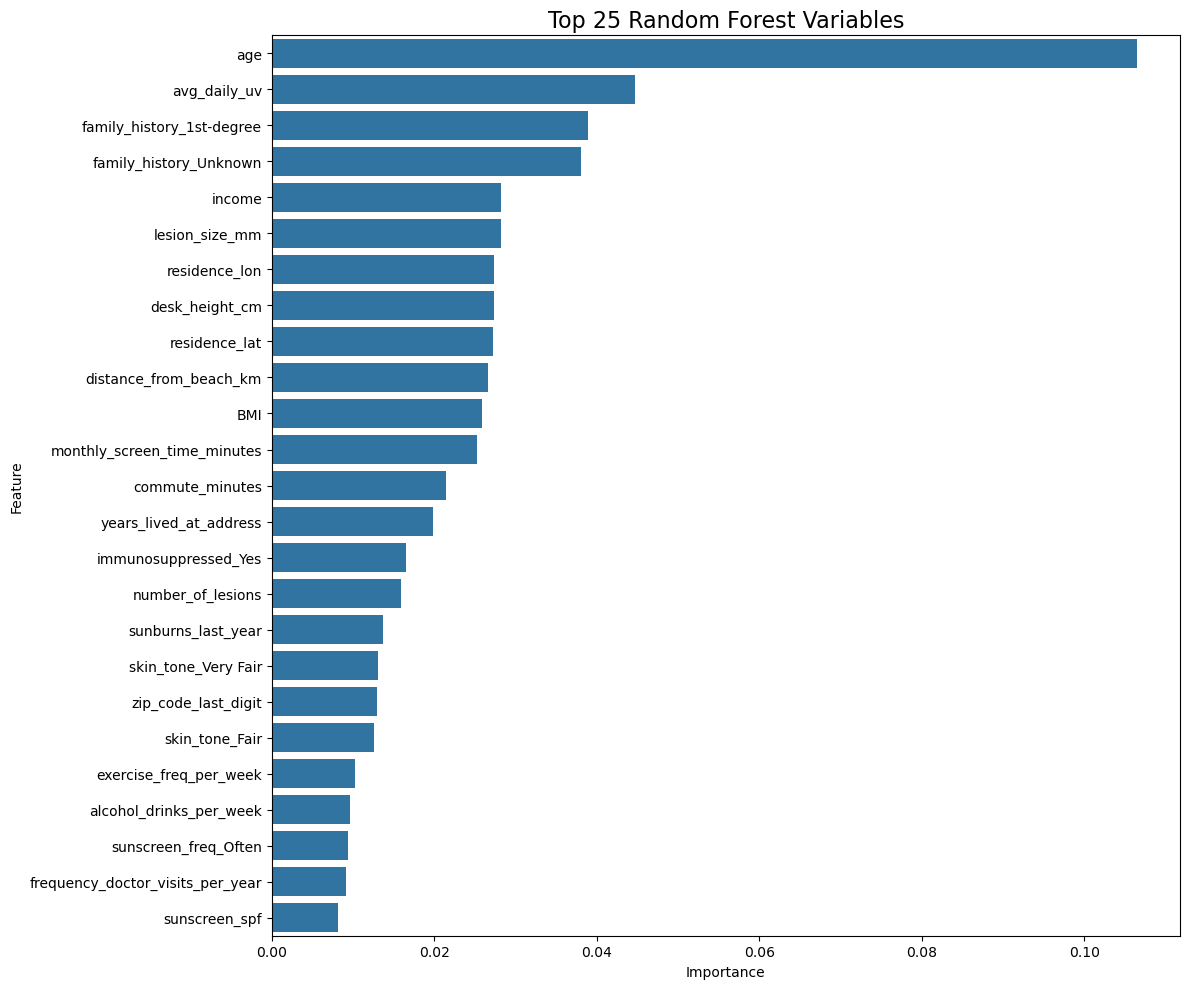

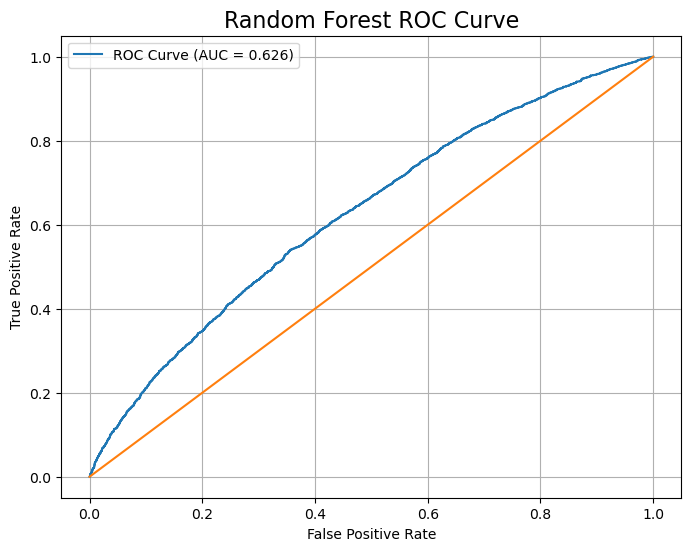

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=800, max_depth=10,          
    min_samples_split=5, min_samples_leaf=3,    
    max_features='sqrt', bootstrap=True,        
    random_state=42, n_jobs=-1)

rf.fit(X_train, y_train) # training rf onto training set

probabilityrf = rf.predict_proba(X_val)[:, 1] # predicted probs

auc_rf = roc_auc_score(y_val, probabilityrf)
print(auc_rf) #AUC

thresholdrf = 0.50
accuracyrf = 0
for threshold in np.arange(0.40, 0.60, 0.01):  #classification threshold for accuracy
    preds = (probabilityrf > threshold).astype(int)
    acc = accuracy_score(y_val, preds)
    if acc > accuracyrf:
        accuracyrf = acc
        thresholdrf = threshold

print(thresholdrf) #threshold
print(accuracyrf) #accuracy

predictionrf = (probabilityrf > thresholdrf).astype(int) #final predictions



importances = pd.DataFrame({ #variable importance sorted by most importnat to least
    'Feature': feature_cols,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 10)) # plotting the top 25 variables used for model
sns.barplot(
    data=importances.head(25),  
    x='Importance', 
    y='Feature')
plt.title("Top 25 Random Forest Variables", fontsize=16)
plt.tight_layout()
plt.show()

fpr, tpr, thresholds = roc_curve(y_val, probabilityrf) # roc curve plot
roc_rf = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_rf:.3f})")
plt.plot([0, 1], [0, 1])  # Diagonal
plt.title("Random Forest ROC Curve", fontsize=16)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()




finalrf = RandomForestClassifier( #final model
    n_estimators=800,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=3,
    max_features='sqrt',
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

finalrf.fit(X_full, y_full)


probabilityrf_final = finalrf.predict_proba(X_test_submission)[:, 1] #probs on test set
predictionrf_final = np.where(probabilityrf_final > thresholdrf, "Malignant", "Benign") #optimal threshold

submissionrf = pd.DataFrame({
    'ID': test_raw['ID'], 
    'Cancer': predictionrf_final
})

submissionrf.to_csv('submission_rf_important_features.csv', index=False)